In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import math
import scipy as sp
from statsmodels import regression
import xlsxwriter
import random
import datetime

import sqlite3
from sqlite3 import Error
from collections import OrderedDict
import uuid


# Data Preparation

In [251]:
#Load data from Excel into a dataframe
data = pd.read_excel('Data.xlsx', index_col=0, skiprows=0)
data.dropna(axis = 0,inplace= True)

# Format dates column in dataframe for SQL storage
data.index = pd.to_datetime(data.index, format='%Y-%m-%d').strftime('%Y-%m-%d %H-%M-%S')
data.head(5)

,SMI Index,CCMP Index,DAX Index,UKX Index,EURUSD Curncy,CHFEUR Curncy,CHFUSD Curncy,CL1 Comdty,XAU Comdty,XAG Comdty,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
Dates,,,,,,,,,,,,,,,,,,,,
2011-01-31 00-00-00,6479.15,2700.08,7077.48,5862.94,1.3698,0.7760,1.0628,92.19,1337.14,28.3900,0.3,58.3,57.6,0.8,8823.2,99.2,54.9,3.3704,74.2,64.79
2011-02-28 00-00-00,6610.44,2782.27,7272.32,5994.01,1.3792,0.7800,1.0758,96.97,1411.88,33.8894,0.3,58.4,58.0,0.8,8887.0,100.1,54.3,3.4272,77.5,72.02
2011-03-31 00-00-00,6357.55,2781.07,7041.31,5908.76,1.4190,0.7695,1.0920,106.72,1437.78,37.7175,0.5,58.4,55.8,0.9,8943.4,100.3,55.2,3.4703,67.5,63.82
2011-04-29 00-00-00,6539.70,2873.54,7514.46,6069.90,1.4807,0.7804,1.1557,113.93,1563.70,47.9050,0.5,58.4,55.2,0.5,9004.9,99.8,53.8,3.2863,69.8,66.02
2011-05-31 00-00-00,6554.71,2835.30,7293.69,5989.99,1.4369,0.8156,1.1718,102.70,1536.23,38.1738,0.3,58.3,55.0,0.0,9075.5,100.4,52.1,3.0607,74.3,61.74


# Data Processing - Split data into 4 subsets

In [252]:
# Create smaller datasets by selecting dates from the index
sample_1 = data[0:30] # 01.01.2011 - 28.06.2013
sample_2 = data[30:60] # 01.07.2013 - 31.12.2015
sample_3 = data[60:90] # 01.01.2016 - 29.06.2018
sample_4 = data[90:120] # 01.07.2018 - 31.12.2020
dataSets = [sample_1, sample_2, sample_3, sample_4]


# Transform dataframe of subsets into a list so it can be inserted into a SQL database
recordsSample1 = sample_1.reset_index().values.tolist()
recordsSample2 = sample_2.reset_index().values.tolist()
recordsSample3 = sample_3.reset_index().values.tolist()
recordsSample4 = sample_4.reset_index().values.tolist()
recordsSample1


[['2011-01-31 00-00-00',
  6479.15,
  2700.08,
  7077.48,
  5862.94,
  1.3698000000000001,
  0.776,
  1.0628,
  92.19,
  1337.14,
  28.39,
  0.3,
  58.3,
  57.6,
  0.8,
  8823.2,
  99.2,
  54.9,
  3.3704,
  74.2,
  64.79],
 ['2011-02-28 00-00-00',
  6610.44,
  2782.27,
  7272.32,
  5994.01,
  1.3792,
  0.78,
  1.0758,
  96.97,
  1411.88,
  33.8894,
  0.3,
  58.4,
  58.0,
  0.8,
  8887.0,
  100.1,
  54.3,
  3.4272,
  77.5,
  72.02],
 ['2011-03-31 00-00-00',
  6357.55,
  2781.07,
  7041.31,
  5908.76,
  1.419,
  0.7695,
  1.092,
  106.72,
  1437.78,
  37.7175,
  0.5,
  58.4,
  55.8,
  0.9,
  8943.4,
  100.3,
  55.2,
  3.4703,
  67.5,
  63.82],
 ['2011-04-29 00-00-00',
  6539.7,
  2873.54,
  7514.46,
  6069.9,
  1.4807000000000001,
  0.7804,
  1.1557,
  113.93,
  1563.7,
  47.905,
  0.5,
  58.4,
  55.2,
  0.5,
  9004.9,
  99.8,
  53.8,
  3.2862999999999998,
  69.8,
  66.02],
 ['2011-05-31 00-00-00',
  6554.71,
  2835.3,
  7293.69,
  5989.99,
  1.4369,
  0.8156,
  1.1718,
  102.7,
  1536.2

# SQL Connection

## Check main connection to SQL

In [253]:
""" create a database connection tool to a SQLite database """

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
 
 
if __name__ == '__main__':
    create_connection(r"Semesterarbeit.db")



2.6.0


## Create tables for subsets and results

In [254]:
def createTableSample(tableName):
    conn = sqlite3.connect(r"Semesterarbeit.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists ''' + tableName + '''
             (Dates TIMESTAMP,
             SMI           INT    NOT NULL,
             CCMP            INT     NOT NULL,
             DAX INT NOT NULL,
             UKX INT NOT NULL,
             EURUSD INT NOT NULL,
             CHFEUR INT NOT NULL,
             CHFUSD INT NOT NULL,
             CL1 INT NOT NULL,
             XAU INT NOT NULL,
             XAG INT NOT NULL,
             CPI CHNG INT NOT NULL,
             USERTOT INT NOT NULL,
             NAPMNMI INT NOT NULL,
             RSTAMOM INT NOT NULL,
             M2 INT NOT NULL,
             EUITEMU INT NOT NULL,
             PMINORD INT NOT NULL,
             USGG10YR INT NOT NULL,
             CONSSENT INT NOT NULL,
             CONCCONF INT)''')
    print('Table', tableName, 'created successfully')
    
def storeDataTableSample(tableName, records):
    conn = sqlite3.connect(r"Semesterarbeit.db")
    c = conn.cursor()
    c.executemany('INSERT INTO ' + tableName + '(Dates,SMI,CCMP,DAX,UKX,EURUSD,CHFEUR,CHFUSD,CL1,XAU,XAG,CPI,USERTOT,NAPMNMI,RSTAMOM,M2,EUITEMU,PMINORD,USGG10YR,CONSSENT,CONCCONF) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', records) 
    conn.commit()
    print('Data successfully inserted into table', tableName)

createTableSample('Sample1')
createTableSample('Sample2')
createTableSample('Sample3')
createTableSample('Sample4')

storeDataTableSample('Sample1', recordsSample1)
storeDataTableSample('Sample2', recordsSample2)
storeDataTableSample('Sample3', recordsSample3)
storeDataTableSample('Sample4', recordsSample4)


Table Sample1 created successfully
Table Sample2 created successfully
Table Sample3 created successfully
Table Sample4 created successfully
Data successfully inserted into table Sample1
Data successfully inserted into table Sample2
Data successfully inserted into table Sample3
Data successfully inserted into table Sample4


# Store Descriptiv Statistic of data sets

In [255]:
# Store in database
sample_1.describe()
sample_2.describe()
sample_3.describe()
sample_4.describe()

,SMI Index,CCMP Index,DAX Index,UKX Index,EURUSD Curncy,CHFEUR Curncy,CHFUSD Curncy,CL1 Comdty,XAU Comdty,XAG Comdty,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,9744.964000,8826.976333,12114.218333,6830.441333,1.136140,0.909983,1.033763,50.726667,1518.288667,17.799930,0.143333,59.116667,55.776667,0.353333,15856.893333,100.690000,50.470000,1.748430,90.630000,118.356667
std,577.416831,1617.061253,873.578790,667.780515,0.033966,0.024403,0.038977,13.029461,252.264682,3.909931,0.247307,2.702372,3.883181,4.959194,1752.452414,7.068988,4.174235,0.892175,10.034326,18.208632
min,8429.300000,6635.280000,9935.840000,5577.270000,1.090300,0.863200,0.981600,18.840000,1192.520000,14.037400,-0.700000,51.300000,41.600000,-14.700000,14159.400000,74.500000,29.300000,0.528200,71.800000,85.700000
25%,9331.175000,7707.405000,11533.650000,6193.852500,1.110775,0.888825,1.005100,43.147500,1295.680000,14.976250,0.025000,57.400000,55.150000,-0.200000,14501.525000,100.025000,49.900000,0.847600,80.975000,101.325000
50%,9831.260000,8142.480000,12278.830000,7101.415000,1.127450,0.914300,1.021500,53.645000,1491.475000,16.507450,0.200000,60.550000,56.500000,0.350000,15093.400000,103.550000,51.250000,1.733400,95.850000,126.450000
75%,10121.250000,9405.137500,12794.307500,7392.790000,1.160350,0.929475,1.039650,58.552500,1719.620000,18.179425,0.200000,60.775000,57.200000,0.775000,17680.475000,104.925000,52.000000,2.597425,98.375000,131.375000
max,10703.510000,12888.280000,13718.780000,7748.760000,1.222500,0.946100,1.130200,73.250000,1975.860000,28.287000,0.500000,61.100000,60.900000,18.100000,19125.800000,106.100000,53.900000,3.143500,101.000000,137.900000


In [256]:
# Pivot table of dataframe 
sample_3.pivot

<bound method DataFrame.pivot of                      SMI Index  CCMP Index  DAX Index  UKX Index  \
Dates                                                              
2016-01-29 00-00-00    8319.81     4613.95    9798.11    6083.79   
2016-02-29 00-00-00    7843.63     4557.95    9495.40    6097.09   
2016-03-31 00-00-00    7807.89     4869.85    9965.51    6174.90   
2016-04-29 00-00-00    7960.85     4775.36   10038.97    6241.89   
2016-05-31 00-00-00    8216.42     4948.06   10262.74    6230.79   
2016-06-30 00-00-00    8020.15     4842.67    9680.09    6504.33   
2016-07-29 00-00-00    8127.20     5162.13   10337.50    6724.43   
2016-08-31 00-00-00    8202.13     5213.22   10592.69    6781.51   
2016-09-30 00-00-00    8139.01     5312.00   10511.02    6899.33   
2016-10-31 00-00-00    7827.74     5189.14   10665.01    6954.22   
2016-11-30 00-00-00    7875.19     5323.68   10640.30    6783.79   
2016-12-30 00-00-00    8219.87     5383.12   11481.06    7142.83   
2017-01-31 00-0

# Normality Test - Create Histograms

In [249]:
for col in data.iteritems(): 
    print('histogram'+col[0])
    fig, ax = plt.subplots()
    indicator=data[col[0]]
    ax.hist(indicator, alpha=0.9, color='blue',bins=20)
    plt.title(col[0])
    plt.savefig('Charts/Hist_'+col[0]+'.png')
    plt.close()

histogramSMI Index
histogramCCMP Index
histogramDAX Index
histogramUKX Index
histogramEURUSD Curncy
histogramCHFEUR Curncy
histogramCHFUSD Curncy
histogramCL1 Comdty
histogramXAU Comdty
histogramXAG Comdty
histogramCPI CHNG Index
histogramUSERTOT Index
histogramNAPMNMI Index
histogramRSTAMOM Index
histogramM2 Index
histogramEUITEMU Index
histogramCPMINORD Index
histogramUSGG10YR Index
histogramCONSSENT Index
histogramCONCCONF Index
histogramconst


# Stationary Test

In [257]:
# Add every column name in a new list
columns = data.columns.tolist()
# Separate asset and macro data
assetColumns = columns[:10]
macroColumns = columns[10:20]

for i in range(len(dataSets)):
    print('Subset', i + 1, '\n')
    print('------------------------')
    for j in assetColumns:
        # ADF Test with 1 lag and constant regression model
        stationaryResult = adfuller(dataSets[i][j])
        if (stationaryResult[1] < 0.1):
            print(j, 'is stationary, because p-value of', stationaryResult[1], 'is < 0.1 --> 90% significant')
        else:
            print(j, 'is NOT stationary, because p-value of', stationaryResult[1], 'is >= 0.1')
    print('------------------------ \n')

Subset 1 

------------------------
SMI Index is NOT stationary, because p-value of 0.9608454461116381 is >= 0.1
CCMP Index is NOT stationary, because p-value of 0.8529288385236653 is >= 0.1
DAX Index is NOT stationary, because p-value of 0.6822203990826865 is >= 0.1
UKX Index is NOT stationary, because p-value of 0.5844319596144637 is >= 0.1
EURUSD Curncy is NOT stationary, because p-value of 0.4752203331919417 is >= 0.1
CHFEUR Curncy is stationary, because p-value of 0.07216060634084084 is < 0.1 --> 90% significant
CHFUSD Curncy is NOT stationary, because p-value of 0.29005519204269203 is >= 0.1
CL1 Comdty is stationary, because p-value of 0.05477188237863833 is < 0.1 --> 90% significant
XAU Comdty is NOT stationary, because p-value of 0.8751110118216217 is >= 0.1
XAG Comdty is NOT stationary, because p-value of 0.3686588409001743 is >= 0.1
------------------------ 

Subset 2 

------------------------
SMI Index is stationary, because p-value of 0.09236478949707638 is < 0.1 --> 90% s

# Chow Test - Function

In [247]:
def chowTest(regressionArray, xArray):
    
    # Whole time series
    RSSd = regressionArray[0].ssr

    # Sample 1 --> subset 1
    RSSb1 = regressionArray[1].ssr
 
    # Sample 2 --> subset 2
    RSSb2 = regressionArray[2].ssr

    # Sample 3 --> subset 3
    RSSb3 = regressionArray[3].ssr

    # Sample 4 --> subset 4
    RSSb4 = regressionArray[4].ssr
    
    #J-Variable (1)
    J = xArray[0].shape[1] #one for all

    #k-Variables (4)
    k1 = xArray[1].shape[1] #Sample 1
    k2 = xArray[2].shape[1] #Sample 2
    k3 = xArray[3].shape[1] #Sample 3
    k4 = xArray[4].shape[1] #Sample 4

    #N1-Variables (4)
    N1 = xArray[1].shape[0] #Sample 1
    N2 = xArray[2].shape[0] #Sample 2
    N3 = xArray[3].shape[0] #Sample 3
    N4 = xArray[4].shape[0] #Sample 4
    
    # Regression Subset 1 + 2
    
    chow1 = ((RSSd-(RSSb1+RSSb2))/J)/((RSSb1+RSSb2)/(N1+N2-2*k1))
    chow1 = sp.stats.f.cdf(chow1, J, N1+N2-2*k1)
    
    # Regression Subset 2 + 3
    
    chow2 = ((RSSd-(RSSb2+RSSb3))/J)/((RSSb2+RSSb3)/(N2+N3-2*k2))
    chow2 = sp.stats.f.cdf(chow2, J, N2+N3-2*k2)

    # Regression Subset 3 + 4
    
    chow3 = ((RSSd-(RSSb3+RSSb4))/J)/((RSSb3+RSSb4)/(N3+N4-2*k3))
    chow3 = sp.stats.f.cdf(chow3, J, N3+N4-2*k3)

    # Regression Subset 1 + 3
    
    chow4 = ((RSSd-(RSSb1+RSSb3))/J)/((RSSb1+RSSb3)/(N1+N3-2*k1))
    chow4 = sp.stats.f.cdf(chow4, J, N1+N3-2*k1)

    # Regression Subset 1 + 4
    
    chow5 = ((RSSd-(RSSb1+RSSb4))/J)/((RSSb1+RSSb4)/(N1+N4-2*k1))
    chow5 = sp.stats.f.cdf(chow5, J, N1+N4-2*k1)

    # Regression Subset 2 + 4
    
    chow6 = ((RSSd-(RSSb2+RSSb4))/J)/((RSSb2+RSSb4)/(N2+N4-2*k2))
    chow6 = sp.stats.f.cdf(chow6, J, N2+N4-2*k2)

    print("Chow Test - Regression Model Subset 1 + 2:", sp.stats.f.cdf(chow1, J, N1+N2-2*k1))
    print("Chow Test - Regression Model Subset 2 + 3:", sp.stats.f.cdf(chow2, J, N2+N3-2*k2))
    print("Chow Test - Regression Model Subset 3 + 4:", sp.stats.f.cdf(chow3, J, N3+N4-2*k3))
    print("Chow Test - Regression Model Subset 1 + 3:", sp.stats.f.cdf(chow4, J, N1+N3-2*k1))
    print("Chow Test - Regression Model Subset 1 + 4:", sp.stats.f.cdf(chow5, J, N1+N4-2*k1))
    print("Chow Test - Regression Model Subset 2 + 4:", sp.stats.f.cdf(chow6, J, N2+N4-2*k2))
    
    chowResults = np.array([chow1,chow2,chow3,chow4,chow5,chow6])
    storeChowTestResult(chowResults.tolist())
    

# Rolling Regression - Function

In [ ]:
def rolling_regression(y, x, window):
    estimate_data = []
    for i in range(window, x.index.size+1):
        x_slice = x.values[i-window:i,:] # always index in np as opposed to pandas, much faster
        y_slice = y.values[i-window:i]
        coeff = np.dot(np.dot(np.linalg.inv(np.dot(x_slice.T, x_slice)), x_slice.T), y_slice)
        estimate_data.append(coeff[0] * x.values[window-1] + coeff[1])
        # === Assemble ========================================================
    estimate = pd.Series(data=estimate_data, index=x.index[window-1:]) 
    return estimate

# Multiple Linear Regression Model - OLS

## Regression - SQL preparation

In [266]:

def createTableRegression():
    conn = sqlite3.connect(r"Semesterarbeit.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists RegressionModelResult
             (
             id INT PRIMARY KEY,
             asset varchar,
             subset int,
             const INT,
             beta1 float,
             x1 varchar,
             beta2 float,
             x2 varchar,
             beta3 float,
             x3 varchar,
             beta4 float,
             x4 varchar,
             beta5 float,
             x5 varchar,
             rsquared float,
             observation int)''')
    print('Table RegressionModelResult created successfully')
    
def storeRegressionModel(olsResult, asset, subset):
    xVars = olsResult.params.index
    rsquared = olsResult.rsquared
    ssr = olsResult.ssr
    nrOfObservations = olsResult.nobs
    
    # Beta 0
    const = olsResult.params[0]
    
    # Beta's of x variables
    b1 = olsResult.params[1]
    b2 = olsResult.params[2]
    b3 = olsResult.params[3]
    b4 = olsResult.params[4]
    b5 = olsResult.params[5]
    
    # x variable names
    x1 = xVars[1]
    x2 = xVars[2]
    x3 = xVars[3]
    x4 = xVars[4]
    x5 = xVars[5]
    
    regressionRecord = np.array([asset, subset, const, b1, x1, b2, x2, b3, x3, b4, x4, b5, x5, rsquared, nrOfObservations])
    print(regressionRecord)
    conn = sqlite3.connect(r"Semesterarbeit.db")
    c = conn.cursor()
    c.execute('INSERT INTO RegressionModelResult(asset,subset,const,beta1,x1,beta2,x2,beta3,x3,beta4,x4,beta5,x5,rsquared,observation) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)', regressionRecord) 
    conn.commit()
    print('Data successfully inserted into RegressionModelResult table')

createTableRegression()


Table RegressionModelResult created successfully


## Chow Test - SQL Preparation 

In [260]:
def createTableChowTestResult():
    conn = sqlite3.connect(r"Semesterarbeit.db")
    c = conn.cursor()
    c.execute('''CREATE TABLE if not exists Results
         (
         id int primary key,
         chowTest1 float,
         chowTest2 float,
         ChowTest3 float,
         ChowTest4 float,
         ChowTest5 float,
         ChowTest6 float)''')


    print("Table created successfully")
    
def storeChowTestResult(record):
    conn = sqlite3.connect(r"Semesterarbeit.db")
    c = conn.cursor()
    c.execute("INSERT INTO Results(ChowTest1,ChowTest2,ChowTest3,ChowTest4,ChowTest5,ChowTest6) VALUES (?,?,?,?,?,?)", record) 
    conn.commit()
    print('Successful ChowTest stored')

createTableChowTestResult()

Table created successfully


In [261]:
index = 1
nrOfCharts = 0

while index <= 5:
    # Select sample of independent marco variables
    independVarColumns = random.sample(macroColumns, k=5)
    print(independVarColumns)
    for i in assetColumns:
        regressionModels = []
        xVars = []
        
        # OLS of whole time series
        mDependVar = data[i]
        mIndependVar = data[independVarColumns]
        mX = sm.add_constant(mIndependVar)
        mModel = sm.OLS(mDependVar, mX, missing='drop')
        mResult = mModel.fit()
    
        mId = str(uuid.uuid4()).replace('-','')
        regressionModels.append(mResult)
        xVars.append(mX)
        
        # OLS of each subset
        for j in range(len(dataSets)):
            
            # Y is depending variable. Depending variable get selected from the according subset.
            dependVar = dataSets[j][i]
            
            # X are the independed variables. Variables get selected from the according subset.
            independVar = dataSets[j][independVarColumns]
            
            print('\n')
            print('Subset:', j + 1)
            print('Y =', i)
            print('x variables:', independVarColumns)
            
            
            # Multivariate OLS generation
            x = sm.add_constant(independVar)
            model = sm.OLS(dependVar, x, missing='drop')
            results = model.fit()
            
            # Rolling Regression Calculation
            rollingOls = rolling_regression(dependVar,independVar,20)
            rollingOls=pd.DataFrame.from_dict(OrderedDict(rollingOls), orient='index')
            rollingOls.columns=["Beta_1","Beta_2","Beta_3", "Beta_4", "Beta_5"]
            
            # Store OLS regression model in array for upcoming chow test. 
            regressionModels.append(results)
            # Store the used independend variables in array for upcoming chow test.
            xVars.append(x)
            
            # Store Regression model in SQL
            id = str(uuid.uuid4()).replace('-','')
            storeRegressionModel(results, i, j+1)
            
            print('\n')
            print(results.summary())
            nrOfCharts += 1
        
        # Execute Chow Test with all regression models from all subsets and the whole timeseries for each asset.
        chowTest(regressionModels, xVars)
    index += 1

print('Number of charts:', nrOfCharts)
    

Table RegressionModelResult created successfully
['USGG10YR Index', 'RSTAMOM Index', 'M2 Index', 'CONCCONF Index', 'CPI CHNG Index']


Subset: 1
Y = SMI Index
x variables: ['USGG10YR Index', 'RSTAMOM Index', 'M2 Index', 'CONCCONF Index', 'CPI CHNG Index']
['SMI Index' '1' '-12389.690118353554' '1091.9633329344879'
 'USGG10YR Index' '90.68029767960934' 'RSTAMOM Index' '1.616274026904216'
 'M2 Index' '9.803573248388563' 'CONCCONF Index' '-334.49213677186003'
 'CPI CHNG Index' '0.8327921598037458' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:              SMI Index   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     23.91
Date:                Sat, 29 May 2021   Prob (F-statistic):           1.35e-08
Time:                        02:34:



Subset: 1
Y = CCMP Index
x variables: ['USGG10YR Index', 'RSTAMOM Index', 'M2 Index', 'CONCCONF Index', 'CPI CHNG Index']
['CCMP Index' '1' '-2744.7270938208767' '211.96110236238258'
 'USGG10YR Index' '-32.827404708166796' 'RSTAMOM Index'
 '0.47805683924353776' 'M2 Index' '7.943096570795958' 'CONCCONF Index'
 '96.09021411384356' 'CPI CHNG Index' '0.8635331992946162' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             CCMP Index   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     30.37
Date:                Sat, 29 May 2021   Prob (F-statistic):           1.24e-09
Time:                        02:34:55   Log-Likelihood:                -177.89
No. Observations:                  30   AIC:                             367.8
Df Res

['DAX Index' '2' '1878.6351050395824' '-2270.0954444516083'
 'USGG10YR Index' '196.75018816614147' 'RSTAMOM Index'
 '1.4836264029678614' 'M2 Index' '-42.665289338095505' 'CONCCONF Index'
 '1811.4948535214862' 'CPI CHNG Index' '0.8742787400435581' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:              DAX Index   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     33.38
Date:                Sat, 29 May 2021   Prob (F-statistic):           4.70e-10
Time:                        02:34:55   Log-Likelihood:                -218.08
No. Observations:                  30   AIC:                             448.2
Df Residuals:                      24   BIC:                             456.6
Df Model:                           5              

Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:              UKX Index   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     4.204
Date:                Sat, 29 May 2021   Prob (F-statistic):            0.00693
Time:                        02:34:55   Log-Likelihood:                -194.90
No. Observations:                  30   AIC:                             401.8
Df Residuals:                      24   BIC:                             410.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

['CHFEUR Curncy' '1' '0.9377523157248365' '-0.022241084419689028'
 'USGG10YR Index' '-0.014497949802001142' 'RSTAMOM Index'
 '-2.254943589232529e-06' 'M2 Index' '-0.0006929081958119451'
 'CONCCONF Index' '0.02220549133230315' 'CPI CHNG Index'
 '0.44551297882789687' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:          CHFEUR Curncy   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     3.857
Date:                Sat, 29 May 2021   Prob (F-statistic):             0.0105
Time:                        02:34:55   Log-Likelihood:                 79.886
No. Observations:                  30   AIC:                            -147.8
Df Residuals:                      24   BIC:                            -139.4
Df Model:                       

x variables: ['USGG10YR Index', 'RSTAMOM Index', 'M2 Index', 'CONCCONF Index', 'CPI CHNG Index']
['CHFUSD Curncy' '3' '0.3731213585083686' '-0.03268440611258794'
 'USGG10YR Index' '-0.011946861685356525' 'RSTAMOM Index'
 '6.171492199963065e-05' 'M2 Index' '-0.0009882044002542806'
 'CONCCONF Index' '0.0561180826525034' 'CPI CHNG Index'
 '0.3771481925060991' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:          CHFUSD Curncy   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     2.906
Date:                Sat, 29 May 2021   Prob (F-statistic):             0.0344
Time:                        02:34:55   Log-Likelihood:                 78.555
No. Observations:                  30   AIC:                            -145.1
Df Residuals:     

['XAU Comdty' '2' '3679.038812535981' '-49.35144041675028'
 'USGG10YR Index' '10.227318898426631' 'RSTAMOM Index'
 '-0.23025693010945703' 'M2 Index' '3.543852834713828' 'CONCCONF Index'
 '8.070369633004475' 'CPI CHNG Index' '0.8004883756979' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             XAU Comdty   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     19.26
Date:                Sat, 29 May 2021   Prob (F-statistic):           1.06e-07
Time:                        02:34:56   Log-Likelihood:                -151.11
No. Observations:                  30   AIC:                             314.2
Df Residuals:                      24   BIC:                             322.6
Df Model:                           5                   

Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             XAG Comdty   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     5.652
Date:                Sat, 29 May 2021   Prob (F-statistic):            0.00140
Time:                        02:34:56   Log-Likelihood:                -82.622
No. Observations:                  30   AIC:                             177.2
Df Residuals:                      24   BIC:                             185.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

['SMI Index' '2' '-20634.608288642252' '0.4578854850977905'
 'CONSSENT Index' '398.0248244630693' 'USERTOT Index'
 '0.49110353543509166' 'M2 Index' '173.22131926642828' 'CPI CHNG Index'
 '143.90838532342877' 'RSTAMOM Index' '0.7081030597624275' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:              SMI Index   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     11.64
Date:                Sat, 29 May 2021   Prob (F-statistic):           8.67e-06
Time:                        02:34:56   Log-Likelihood:                -204.71
No. Observations:                  30   AIC:                             421.4
Df Residuals:                      24   BIC:                             429.8
Df Model:                           5                


                            OLS Regression Results                            
Dep. Variable:              DAX Index   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     25.16
Date:                Sat, 29 May 2021   Prob (F-statistic):           8.14e-09
Time:                        02:34:56   Log-Likelihood:                -221.71
No. Observations:                  30   AIC:                             455.4
Df Residuals:                      24   BIC:                             463.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7.646e+04   4.35e+04      1

['UKX Index' '4' '8738.681126072794' '22.14975226172953' 'CONSSENT Index'
 '-8.66776997750921' 'USERTOT Index' '-0.21991463269601286' 'M2 Index'
 '563.9615855632601' 'CPI CHNG Index' '8.677945620405467' 'RSTAMOM Index'
 '0.7729041381180782' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:              UKX Index   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     16.34
Date:                Sat, 29 May 2021   Prob (F-statistic):           4.80e-07
Time:                        02:34:57   Log-Likelihood:                -214.94
No. Observations:                  30   AIC:                             441.9
Df Residuals:                      24   BIC:                             450.3
Df Model:                           5                    

['CHFEUR Curncy' '2' '6.2205070739709' '0.006766941393611349'
 'CONSSENT Index' '-0.12145296792310811' 'USERTOT Index'
 '0.00010658618179978902' 'M2 Index' '0.03728130742313816'
 'CPI CHNG Index' '0.0015292264831645586' 'RSTAMOM Index'
 '0.848080262488934' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:          CHFEUR Curncy   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     26.80
Date:                Sat, 29 May 2021   Prob (F-statistic):           4.37e-09
Time:                        02:34:57   Log-Likelihood:                 70.368
No. Observations:                  30   AIC:                            -128.7
Df Residuals:                      24   BIC:                            -120.3
Df Model:                           5    

strong multicollinearity or other numerical problems.
Chow Test - Regression Model Subset 1 + 2: 0.5636553269056079
Chow Test - Regression Model Subset 2 + 3: 0.5636562361213175
Chow Test - Regression Model Subset 3 + 4: 0.5636562361213763
Chow Test - Regression Model Subset 1 + 3: 0.5636562302494119
Chow Test - Regression Model Subset 1 + 4: 0.5636562350237889
Chow Test - Regression Model Subset 2 + 4: 0.5636562361213728
Successful ChowTest stored


Subset: 1
Y = CL1 Comdty
x variables: ['CONSSENT Index', 'USERTOT Index', 'M2 Index', 'CPI CHNG Index', 'RSTAMOM Index']
['CL1 Comdty' '1' '501.4332880695342' '0.3047150721755143'
 'CONSSENT Index' '-6.752771741831477' 'USERTOT Index'
 '-0.0035324305766515456' 'M2 Index' '11.39006053567595' 'CPI CHNG Index'
 '-1.6696247612065207' 'RSTAMOM Index' '0.24273314657606193' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:            

strong multicollinearity or other numerical problems.


Subset: 2
Y = XAU Comdty
x variables: ['CONSSENT Index', 'USERTOT Index', 'M2 Index', 'CPI CHNG Index', 'RSTAMOM Index']
['XAU Comdty' '2' '6120.991899375571' '2.7304851055013017'
 'CONSSENT Index' '-57.71771451639677' 'USERTOT Index'
 '-0.14932936104920536' 'M2 Index' '-44.67805109649106' 'CPI CHNG Index'
 '8.711030273509493' 'RSTAMOM Index' '0.7477001324488833' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             XAU Comdty   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     14.22
Date:                Sat, 29 May 2021   Prob (F-statistic):           1.62e-06
Time:                        02:34:57   Log-Likelihood:                -154.63
No. Observations:                 

                            OLS Regression Results                            
Dep. Variable:             XAG Comdty   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     27.76
Date:                Sat, 29 May 2021   Prob (F-statistic):           3.07e-09
Time:                        02:34:57   Log-Likelihood:                -54.250
No. Observations:                  30   AIC:                             120.5
Df Residuals:                      24   BIC:                             128.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -52.7862     16.324     -3.

['CCMP Index' '3' '-74064.62773454338' '42.14601390982081'
 'CONCCONF Index' '140.06900537537194' 'USGG10YR Index'
 '-7.848784729078716' 'CPMINORD Index' '1255.7873124704483'
 'USERTOT Index' '-36.342674048078834' 'RSTAMOM Index'
 '0.9156744611639744' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             CCMP Index   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     52.12
Date:                Sat, 29 May 2021   Prob (F-statistic):           4.15e-12
Time:                        02:34:58   Log-Likelihood:                -210.36
No. Observations:                  30   AIC:                             432.7
Df Residuals:                      24   BIC:                             441.1
Df Model:                           5         

Chow Test - Regression Model Subset 1 + 2: 0.5636562361213763
Chow Test - Regression Model Subset 2 + 3: 0.5636562361213763
Chow Test - Regression Model Subset 3 + 4: 0.5636562361213655
Chow Test - Regression Model Subset 1 + 3: 0.5636562361213763
Chow Test - Regression Model Subset 1 + 4: 0.5636562361207157
Chow Test - Regression Model Subset 2 + 4: 0.5636562361204019
Successful ChowTest stored


Subset: 1
Y = UKX Index
x variables: ['CONCCONF Index', 'USGG10YR Index', 'CPMINORD Index', 'USERTOT Index', 'RSTAMOM Index']
['UKX Index' '1' '-17800.531678288447' '17.270661135766765'
 'CONCCONF Index' '127.84327138316394' 'USGG10YR Index'
 '18.69737116802503' 'CPMINORD Index' '364.37861496171854' 'USERTOT Index'
 '-3.220573417180276' 'RSTAMOM Index' '0.34794740131313373' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:              UKX Index   R-squared:                       

Successful ChowTest stored


Subset: 1
Y = EURUSD Curncy
x variables: ['CONCCONF Index', 'USGG10YR Index', 'CPMINORD Index', 'USERTOT Index', 'RSTAMOM Index']
['EURUSD Curncy' '1' '-0.7966935376780064' '-0.0031407617393684733'
 'CONCCONF Index' '0.08587637974609907' 'USGG10YR Index'
 '0.0015812324498731128' 'CPMINORD Index' '0.03535031659665938'
 'USERTOT Index' '-0.002412651283852707' 'RSTAMOM Index'
 '0.7807861704095092' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:          EURUSD Curncy   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     17.10
Date:                Sat, 29 May 2021   Prob (F-statistic):           3.18e-07
Time:                        02:34:58   Log-Likelihood:                 62.186
No. Observations:            

['CHFEUR Curncy' '2' '0.5093472292317962' '0.0018021026861279547'
 'CONCCONF Index' '-0.06732662499258046' 'USGG10YR Index'
 '-0.015740367251098064' 'CPMINORD Index' '0.019635715891340944'
 'USERTOT Index' '0.010384334517151816' 'RSTAMOM Index'
 '0.7709350113968354' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:          CHFEUR Curncy   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     16.15
Date:                Sat, 29 May 2021   Prob (F-statistic):           5.30e-07
Time:                        02:34:58   Log-Likelihood:                 64.208
No. Observations:                  30   AIC:                            -116.4
Df Residuals:                      24   BIC:                            -108.0
Df Model:                      

Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             CL1 Comdty   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     29.00
Date:                Sat, 29 May 2021   Prob (F-statistic):           1.98e-09
Time:                        02:34:58   Log-Likelihood:                -109.72
No. Observations:                  30   AIC:                             231.4
Df Residuals:                      24   BIC:                             239.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

['XAG Comdty' '1' '67.9665965979475' '-0.2532697725861478'
 'CONCCONF Index' '3.3006078664777494' 'USGG10YR Index'
 '0.21466889438491776' 'CPMINORD Index' '-0.6570595204539149'
 'USERTOT Index' '0.9296489840042295' 'RSTAMOM Index' '0.3605004201658385'
 '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             XAG Comdty   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     2.706
Date:                Sat, 29 May 2021   Prob (F-statistic):             0.0447
Time:                        02:34:59   Log-Likelihood:                -87.589
No. Observations:                  30   AIC:                             187.2
Df Residuals:                      24   BIC:                             195.6
Df Model:                           5        

['SMI Index' '3' '7818.390726940903' '-12.513784756072482'
 'CONSSENT Index' '-48.31840724887036' 'CPMINORD Index'
 '39.133826355619455' 'CONCCONF Index' '125.715960647045' 'CPI CHNG Index'
 '-24.362711206420954' 'RSTAMOM Index' '0.6679070647033511' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:              SMI Index   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     9.654
Date:                Sat, 29 May 2021   Prob (F-statistic):           3.77e-05
Time:                        02:34:59   Log-Likelihood:                -212.10
No. Observations:                  30   AIC:                             436.2
Df Residuals:                      24   BIC:                             444.6
Df Model:                           5           

strong multicollinearity or other numerical problems.
Chow Test - Regression Model Subset 1 + 2: 0.5636562361213763
Chow Test - Regression Model Subset 2 + 3: 0.5636562361213763
Chow Test - Regression Model Subset 3 + 4: 0.5636562361213763
Chow Test - Regression Model Subset 1 + 3: 0.5636562361213763
Chow Test - Regression Model Subset 1 + 4: 0.5636562361213763
Chow Test - Regression Model Subset 2 + 4: 0.5636562361213763
Successful ChowTest stored


Subset: 1
Y = DAX Index
x variables: ['CONSSENT Index', 'CPMINORD Index', 'CONCCONF Index', 'CPI CHNG Index', 'RSTAMOM Index']
['DAX Index' '1' '-1336.2894491230054' '56.44347815615197'
 'CONSSENT Index' '69.11529436667553' 'CPMINORD Index' '9.792190498626098'
 'CONCCONF Index' '72.1297328115902' 'CPI CHNG Index' '67.5343034751545'
 'RSTAMOM Index' '0.516157515556239' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:           

Chow Test - Regression Model Subset 1 + 2: 0.5636562361213451
Chow Test - Regression Model Subset 2 + 3: 0.5636562361213763
Chow Test - Regression Model Subset 3 + 4: 0.5636562356157475
Chow Test - Regression Model Subset 1 + 3: 0.5636562361211614
Chow Test - Regression Model Subset 1 + 4: 0.5636561410982778
Chow Test - Regression Model Subset 2 + 4: 0.5636562359915823
Successful ChowTest stored


Subset: 1
Y = EURUSD Curncy
x variables: ['CONSSENT Index', 'CPMINORD Index', 'CONCCONF Index', 'CPI CHNG Index', 'RSTAMOM Index']
['EURUSD Curncy' '1' '0.8768053686971613' '-0.004927857969451457'
 'CONSSENT Index' '0.01581185159873384' 'CPMINORD Index'
 '3.3723988492162515e-05' 'CONCCONF Index' '0.0568345170238404'
 'CPI CHNG Index' '-0.002401565371856873' 'RSTAMOM Index'
 '0.5686293208800282' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:          EURUSD Curncy   R-squared:  

                            OLS Regression Results                            
Dep. Variable:          CHFEUR Curncy   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     5.376
Date:                Sat, 29 May 2021   Prob (F-statistic):            0.00187
Time:                        02:34:59   Log-Likelihood:                 80.604
No. Observations:                  30   AIC:                            -149.2
Df Residuals:                      24   BIC:                            -140.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1556      0.067     17.

['CL1 Comdty' '2' '-241.69073009900367' '-0.5742798613777347'
 'CONSSENT Index' '9.235142159389586' 'CPMINORD Index'
 '-1.1808871174588411' 'CONCCONF Index' '4.396164699052145'
 'CPI CHNG Index' '3.133546722143283' 'RSTAMOM Index' '0.8077508086759277'
 '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             CL1 Comdty   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     20.17
Date:                Sat, 29 May 2021   Prob (F-statistic):           6.90e-08
Time:                        02:35:00   Log-Likelihood:                -114.26
No. Observations:                  30   AIC:                             240.5
Df Residuals:                      24   BIC:                             248.9
Df Model:                           5        

                            OLS Regression Results                            
Dep. Variable:             XAG Comdty   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     4.360
Date:                Sat, 29 May 2021   Prob (F-statistic):            0.00578
Time:                        02:35:00   Log-Likelihood:                -84.602
No. Observations:                  30   AIC:                             181.2
Df Residuals:                      24   BIC:                             189.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             23.5548     24.822      0.

                            OLS Regression Results                            
Dep. Variable:              SMI Index   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     26.75
Date:                Sat, 29 May 2021   Prob (F-statistic):           4.45e-09
Time:                        02:35:00   Log-Likelihood:                -211.02
No. Observations:                  30   AIC:                             434.0
Df Residuals:                      24   BIC:                             442.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -9360.5669   3.38e+04     -0.

['CCMP Index' '2' '-18453.1647453528' '-200.1101158996771'
 'USGG10YR Index' '0.9290215446571892' 'CONSSENT Index'
 '306.9943603862587' 'CPI CHNG Index' '0.6551976692045477' 'M2 Index'
 '266.932274898933' 'USERTOT Index' '0.9057651713955511' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             CCMP Index   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     46.14
Date:                Sat, 29 May 2021   Prob (F-statistic):           1.55e-11
Time:                        02:35:00   Log-Likelihood:                -190.26
No. Observations:                  30   AIC:                             392.5
Df Residuals:                      24   BIC:                             400.9
Df Model:                           5                   

Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:              DAX Index   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     26.74
Date:                Sat, 29 May 2021   Prob (F-statistic):           4.47e-09
Time:                        02:35:00   Log-Likelihood:                -220.94
No. Observations:                  30   AIC:                             453.9
Df Residuals:                      24   BIC:                             462.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

strong multicollinearity or other numerical problems.
Chow Test - Regression Model Subset 1 + 2: 0.5636562361213763
Chow Test - Regression Model Subset 2 + 3: 0.5636562361213763
Chow Test - Regression Model Subset 3 + 4: 0.5636562360127338
Chow Test - Regression Model Subset 1 + 3: 0.5636562361213763
Chow Test - Regression Model Subset 1 + 4: 0.5636562360139379
Chow Test - Regression Model Subset 2 + 4: 0.5636562358604809
Successful ChowTest stored


Subset: 1
Y = EURUSD Curncy
x variables: ['USGG10YR Index', 'CONSSENT Index', 'CPI CHNG Index', 'M2 Index', 'USERTOT Index']
['EURUSD Curncy' '1' '2.036709079874795' '0.0914093274452767'
 'USGG10YR Index' '-0.004389026218615991' 'CONSSENT Index'
 '0.009920057496224266' 'CPI CHNG Index' '3.0281119385603593e-05'
 'M2 Index' '-0.014971325691337412' 'USERTOT Index' '0.8054585221906121'
 '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Varia

strong multicollinearity or other numerical problems.


Subset: 4
Y = CHFEUR Curncy
x variables: ['USGG10YR Index', 'CONSSENT Index', 'CPI CHNG Index', 'M2 Index', 'USERTOT Index']
['CHFEUR Curncy' '4' '0.9892325953373147' '-0.032926746933034226'
 'USGG10YR Index' '0.0011146495851191776' 'CONSSENT Index'
 '-0.007477134189008139' 'CPI CHNG Index' '-9.583087136201784e-07'
 'M2 Index' '-0.0018003775609332362' 'USERTOT Index' '0.9229382831210385'
 '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:          CHFEUR Curncy   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     57.49
Date:                Sat, 29 May 2021   Prob (F-statistic):           1.42e-12
Time:                        02:35:01   Log-Likelihood:                 107.78
No. Obse

Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             CL1 Comdty   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     1.921
Date:                Sat, 29 May 2021   Prob (F-statistic):              0.128
Time:                        02:35:02   Log-Likelihood:                -97.222
No. Observations:                  30   AIC:                             206.4
Df Residuals:                      24   BIC:                             214.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

['XAU Comdty' '2' '3836.4731137766175' '-105.25113708258618'
 'USGG10YR Index' '-0.6247577799395216' 'CONSSENT Index'
 '16.83694663503931' 'CPI CHNG Index' '-0.1923215876834894' 'M2 Index'
 '-1.5218076418508417' 'USERTOT Index' '0.7742025414048225' '30.0']
Data successfully inserted into RegressionModelResult table


                            OLS Regression Results                            
Dep. Variable:             XAU Comdty   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     16.46
Date:                Sat, 29 May 2021   Prob (F-statistic):           4.49e-07
Time:                        02:35:02   Log-Likelihood:                -152.97
No. Observations:                  30   AIC:                             317.9
Df Residuals:                      24   BIC:                             326.3
Df Model:                           5            

# Plot Rolling Regressions - Example

                           Beta_1        Beta_2        Beta_3        Beta_4  \
2011-02-28 00-00-00  4.077712e+04  8.129663e+06  8.073974e+06  1.078883e+07   
2011-03-31 00-00-00 -9.465611e+03 -1.925959e+06 -1.912764e+06 -2.555993e+06   
2011-04-29 00-00-00 -4.655039e+15 -9.326653e+17 -9.262762e+17 -1.237743e+18   
2011-05-31 00-00-00 -3.539920e+03 -7.028012e+05 -6.979870e+05 -9.326789e+05   
2011-06-30 00-00-00  1.874985e+06  3.675135e+08  3.649961e+08  4.877147e+08   

                           Beta_5  
2011-02-28 00-00-00  1.237278e+09  
2011-03-31 00-00-00 -2.931471e+08  
2011-04-29 00-00-00 -1.419487e+20  
2011-05-31 00-00-00 -1.069592e+08  
2011-06-30 00-00-00  5.592820e+10  


<function matplotlib.pyplot.show(*args, **kw)>

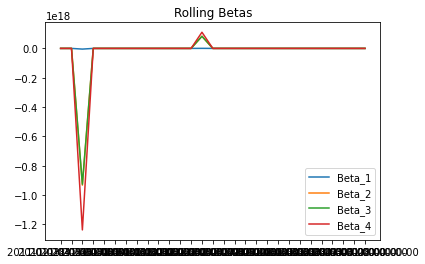

<Figure size 1440x144 with 0 Axes>

In [262]:
dependVar = sample_1['SMI Index']
independVar = sample_1[['CPI CHNG Index', 'USERTOT Index', 'NAPMNMI Index', 'CONSSENT Index', 'M2 Index']]

cdf = rolling_regression(dependVar,independVar,2)

cdf=pd.DataFrame.from_dict(OrderedDict(cdf), orient='index')
# print(cdf)
cdf.columns=["Beta_1","Beta_2","Beta_3", "Beta_4", "Beta_5"]
print(cdf.head(5))
plt.plot(cdf[["Beta_1","Beta_2", "Beta_3", "Beta_4"]])
labels=["Beta_1","Beta_2","Beta_3", "Beta_4", "Beta_5"]
plt.legend(labels)
plt.title('Rolling Betas')
plt.figure(figsize=(20, 2))
plt.show



# Check Correlation between the marco variables

In [263]:
corr = data[macroColumns].corr()

In [264]:
corr

,CPI CHNG Index,USERTOT Index,NAPMNMI Index,RSTAMOM Index,M2 Index,EUITEMU Index,CPMINORD Index,USGG10YR Index,CONSSENT Index,CONCCONF Index
CPI CHNG Index,1.000000,0.116132,0.261534,0.348134,-0.012462,0.331547,0.147957,0.188202,-0.053499,-0.006298
USERTOT Index,0.116132,1.000000,0.544187,-0.107868,-0.052483,0.831195,-0.106354,0.436163,0.685385,0.582447
NAPMNMI Index,0.261534,0.544187,1.000000,0.066164,0.106342,0.658955,0.145218,0.383880,0.497433,0.437401
RSTAMOM Index,0.348134,-0.107868,0.066164,1.000000,0.044591,0.073242,0.023396,-0.003697,-0.060330,-0.042316
M2 Index,-0.012462,-0.052483,0.106342,0.044591,1.000000,0.151630,-0.029808,-0.494269,0.449316,0.676449
EUITEMU Index,0.331547,0.831195,0.658955,0.073242,0.151630,1.000000,0.058625,0.422658,0.611318,0.611709
CPMINORD Index,0.147957,-0.106354,0.145218,0.023396,-0.029808,0.058625,1.000000,0.278842,-0.089296,-0.049668
USGG10YR Index,0.188202,0.436163,0.383880,-0.003697,-0.494269,0.422658,0.278842,1.000000,0.150379,0.071142
CONSSENT Index,-0.053499,0.685385,0.497433,-0.060330,0.449316,0.611318,-0.089296,0.150379,1.000000,0.897165
CONCCONF Index,-0.006298,0.582447,0.437401,-0.042316,0.676449,0.611709,-0.049668,0.071142,0.897165,1.000000


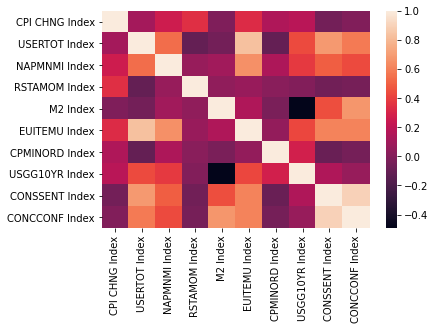

In [43]:
import seaborn as sns
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)